<a href="https://colab.research.google.com/github/FrancescaSrc/pytorch_challenge/blob/master/0_968215FlowerProject_densenet201withNLLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x582e8000 @  0x7fe7e7aba2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.optim import lr_scheduler
from collections import OrderedDict

%matplotlib inline

In [0]:
#!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
#!unzip -qq flower_data.zip

In [4]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
from PIL import Image

    100% |████████████████████████████████| 5.6MB 7.0MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
batch_size=32
num_workers=0

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.Resize(226),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(226),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'drive/My Drive/Colab Notebooks/flower_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
import json
with open('drive/My Drive/Colab Notebooks/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
#cat_to_name = {int(n):cat_to_name[n] for n in cat_to_name}
#sorted_keys = sorted(cat_to_name.keys())
classes=[]
for i in image_datasets['train'].classes:
    classes.append(cat_to_name[i])
print(classes)

['pink primrose', 'globe thistle', 'blanket flower', 'trumpet creeper', 'blackberry lily', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'hard-leaved pocket orchid', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'canterbury bells', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'sweet pea', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'english marigold', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'tiger lily', 'pink-yellow dahli

In [0]:
import json
with open('drive/My Drive/Colab Notebooks/cat_to_name.json', 'r') as f:
    label_map = json.load(f)

In [10]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
print(torch.cuda.is_available())
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    


True
CUDA is available!  Training on GPU ...


In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        if epoch == 20:
          for param in model_ft.parameters():
            param.requires_grad = True
            
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                print('Accuracy increased ({:.6f} --> {:.6f}).  Saving model classifier17dec ...'.format(best_acc, epoch_acc))
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # save model if loss has decreased   
                model_ft.class_to_idx = image_datasets['train'].class_to_idx
                model_ft.cpu()
                torch.save({'model': 'densenet161',
                            'state_dict': model_ft.state_dict(), 
                            'class_to_idx': model_ft.class_to_idx}, 
                            'drive/My Drive/Colab Notebooks/classifier17dec.pth')
                model_ft.cuda()
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [31]:
model_ft = models.densenet161(pretrained=True)
model_ft.classifier

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Linear(in_features=2208, out_features=1000, bias=True)

In [0]:

n_inputs = 2208
# Freeze parameters so we don't backprop through them
for param in model_ft.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(n_inputs, 500)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.2)),
                          ('fc2', nn.Linear(500, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model_ft.classifier = classifier
model_ft = model_ft.to(device)

# Criteria NLLLoss which is recommended with Softmax final layer
criterion = nn.NLLLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
#try with
optimizer_ft = optim.Adam(model_ft.classifier.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)






In [34]:
import time
import copy
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------
train Loss: 2.3049 Acc: 0.5058
valid Loss: 0.9102 Acc: 0.8093
Accuracy increased (0.000000 --> 0.809291).  Saving model classifier17dec ...

Epoch 1/29
----------
train Loss: 0.7791 Acc: 0.8109
valid Loss: 0.4749 Acc: 0.8985
Accuracy increased (0.809291 --> 0.898533).  Saving model classifier17dec ...

Epoch 2/29
----------
train Loss: 0.4876 Acc: 0.8733
valid Loss: 0.3989 Acc: 0.9046
Accuracy increased (0.898533 --> 0.904645).  Saving model classifier17dec ...

Epoch 3/29
----------
train Loss: 0.3543 Acc: 0.9060
valid Loss: 0.3399 Acc: 0.9095
Accuracy increased (0.904645 --> 0.909535).  Saving model classifier17dec ...

Epoch 4/29
----------
train Loss: 0.2940 Acc: 0.9214
valid Loss: 0.2604 Acc: 0.9364
Accuracy increased (0.909535 --> 0.936430).  Saving model classifier17dec ...

Epoch 5/29
----------
train Loss: 0.2468 Acc: 0.9312
valid Loss: 0.2788 Acc: 0.9218

Epoch 6/29
----------
train Loss: 0.2103 Acc: 0.9387
valid Loss: 0.2183 Acc: 0.9474
Accuracy increas

In [0]:
model_ft.class_to_idx = image_datasets['train'].class_to_idx
model_ft.cpu()
torch.save({'model': 'densenet161',
            'state_dict': model_ft.state_dict(), 
            'class_to_idx': model_ft.class_to_idx}, 
            'drive/My Drive/Colab Notebooks/classifier17dec.pth')

In [0]:
state = {'epoch': epoch + 1, 'state_dict': model.state_dict(),
             'optimizer': optimizer.state_dict(), 'losslogger': losslogger, }
torch.save(state, 'drive/My Drive/Colab Notebooks/classifier25retrain.pth')

In [0]:
def load_checkpoint(model, optimizer, losslogger, filename='checkpoint.pth.tar'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        losslogger = checkpoint['losslogger']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch, losslogger

In [0]:
def load_model(checkpoint_path):
    chpt = torch.load(checkpoint_path)
    
    if chpt['model'] == 'densenet161':
        model = models.densenet161(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
    else:
      print("Sorry base architecture note recognized")
      
    
    model.class_to_idx = chpt['class_to_idx']
    from collections import OrderedDict
    # Create the classifier
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(n_inputs, 500)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.2)),
                          ('fc2', nn.Linear(500, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
    # Put the classifier on the pretrained network
    model.classifier = classifier
    
    model.load_state_dict(chpt['state_dict'])
    
    return model

In [82]:
model2 = load_model('drive/My Drive/Colab Notebooks/classifier17dec.pth')
model2.cuda()

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [0]:
def imshow1(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
   

In [0]:
def visualize_model(model, num_images=6):
    model.cuda()
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            print(labels)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            print(inputs.size()[0])
            
            
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far) #subplot(nrows, ncols, index, **kwargs)
                #ax = plt.subplot(num_images//2, 2, j+1, xticks=[], yticks=[])
                ax.axis('off')
                ax.set_title('{}'.format(classes[preds[j]]) + ' ({})'.format(classes[labels[j]]), color=("green" if preds[j]==labels[j] else "red"))
               
                imshow1(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

tensor([56, 98, 89, 84,  5, 66, 52, 82, 77, 90, 48, 72, 74, 43, 37, 76, 51, 52,
        46, 54, 88, 24, 35, 43, 70, 18, 40, 72, 12, 86,  7, 96],
       device='cuda:0')
32


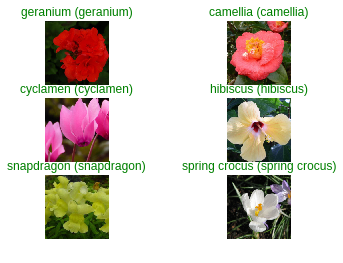

In [87]:
visualize_model(model2)

tensor([90, 49, 31, 99, 98, 16, 47, 99, 24,  2, 74, 36, 11, 32, 89, 73, 74, 15,
        70, 76, 52, 15, 94, 63, 47, 87, 77, 74, 38,  0, 23, 83],
       device='cuda:0')
32


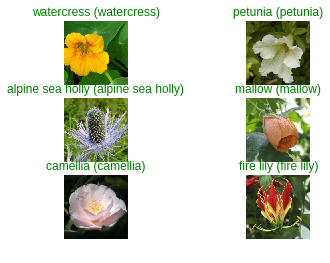

In [41]:
visualize_model(model_ft)

In [0]:
def calc_accuracy(model, data):
    model.eval()
    model.to(device)    
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(data):
            inputs, labels = inputs.cuda(), labels.cuda()
            # obtain the outputs from the model
            outputs = model.forward(inputs)
            # max provides the (maximum probability, max value)
            _, predicted = outputs.max(dim=1)
            # check the 
            if idx == 0:
                print("predicted flower type", predicted) #the predicted class
                print("how sure is model", torch.exp(_)) # the predicted probability
            equals = predicted == labels.data
            if idx == 0:
                print("correct or not", equals)
            print("accuracy for each batch", equals.float().mean())

In [89]:
calc_accuracy(model2, dataloaders['valid'])

predicted flower type tensor([32, 47, 21, 76, 11, 77, 73, 23, 46, 78, 48, 49, 68, 26, 73, 77, 45, 89,
        19, 72, 40, 91, 97, 84, 78, 70, 18, 82, 89, 52, 93, 76],
       device='cuda:0')
how sure is model tensor([0.9997, 0.8593, 0.9997, 1.0000, 0.9994, 1.0000, 0.9968, 1.0000, 0.9999,
        0.9998, 0.9974, 1.0000, 0.9817, 1.0000, 0.9995, 1.0000, 0.9901, 0.9981,
        0.9997, 0.9808, 0.9460, 0.9996, 0.9667, 0.9365, 1.0000, 1.0000, 0.9899,
        0.9997, 1.0000, 0.8460, 1.0000, 1.0000], device='cuda:0')
correct or not tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0', dtype=torch.uint8)
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(0.9375, device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(0.9062, device='cuda:0')
a

In [47]:
calc_accuracy(model, dataloaders['valid'])

predicted flower type tensor([26, 15, 88, 49, 74, 75, 30, 78, 73, 80, 11, 53, 89, 38, 75, 23, 52, 45,
        52, 73, 45, 98, 59, 47,  1, 76, 49, 29, 64, 38, 15, 26],
       device='cuda:0')
how sure is model tensor([0.9999, 0.9841, 0.9694, 0.9988, 0.9986, 0.6490, 1.0000, 0.9984, 0.9999,
        1.0000, 1.0000, 1.0000, 0.9981, 0.9999, 1.0000, 0.9522, 0.9761, 0.9997,
        0.9998, 1.0000, 0.9999, 0.9916, 1.0000, 1.0000, 0.9999, 0.9302, 0.9995,
        1.0000, 1.0000, 1.0000, 0.9995, 1.0000], device='cuda:0')
correct or not tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0', dtype=torch.uint8)
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(0.9688, device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(0.9688, device='cuda:0')
a

In [48]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))

model_ft.eval() # eval mode

# iterate over test data
for data, target in dataloaders['valid']:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
       data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(dataloaders['valid'].dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))



Test Loss: 0.145587



In [49]:
for i in range(102):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Accuracy of pink primrose: 100% ( 8/ 8)
Test Accuracy of globe thistle: 100% ( 4/ 4)
Test Accuracy of blanket flower: 100% ( 6/ 6)
Test Accuracy of trumpet creeper: 100% ( 5/ 5)
Test Accuracy of blackberry lily: 100% ( 6/ 6)
Test Accuracy of snapdragon: 90% ( 9/10)
Test Accuracy of colt's foot: 100% ( 5/ 5)
Test Accuracy of king protea: 100% ( 5/ 5)
Test Accuracy of spear thistle: 100% ( 1/ 1)
Test Accuracy of yellow iris: 100% ( 7/ 7)
Test Accuracy of globe-flower: 100% ( 2/ 2)
Test Accuracy of purple coneflower: 100% (16/16)
Test Accuracy of peruvian lily: 90% (10/11)
Test Accuracy of balloon flower: 100% ( 4/ 4)
Test Accuracy of hard-leaved pocket orchid: 100% ( 6/ 6)
Test Accuracy of giant white arum lily: 100% ( 7/ 7)
Test Accuracy of fire lily: 100% ( 4/ 4)
Test Accuracy of pincushion flower: 100% ( 8/ 8)
Test Accuracy of fritillary: 100% (12/12)
Test Accuracy of red ginger: 100% ( 5/ 5)
Test Accuracy of grape hyacinth: 100% ( 2/ 2)
Test Accuracy of corn poppy: 66% ( 2/ 3)
T

In [0]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 226))
    else:
        img.thumbnail((226, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

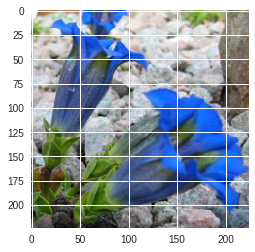

In [53]:
image_path = 'drive/My Drive/Colab Notebooks/flower_data/valid/28/image_05272.jpg'
img = process_image(image_path)
imshow(img)

In [56]:
# Process image
img = process_image(image_path) 
img = torch.from_numpy(img).type(torch.cuda.FloatTensor) 
img.unsqueeze_(0)
# Predict top 5
#moved loaded model to gpu
probs = torch.exp(model.cuda().forward(img)) 
top_probs, top_labs = probs.topk(5)
top_probs.cpu()
top_labs.cpu()

tensor([[23, 91, 20, 66, 25]])

In [0]:
top_probs = top_probs.detach().cpu().numpy().tolist()[0]
top_labs = top_labs.detach().cpu().numpy().tolist()[0]

In [58]:
idx_to_class = {val: key for key, val in model.class_to_idx.items()}
print(idx_to_class)

{0: '1', 1: '10', 2: '100', 3: '101', 4: '102', 5: '11', 6: '12', 7: '13', 8: '14', 9: '15', 10: '16', 11: '17', 12: '18', 13: '19', 14: '2', 15: '20', 16: '21', 17: '22', 18: '23', 19: '24', 20: '25', 21: '26', 22: '27', 23: '28', 24: '29', 25: '3', 26: '30', 27: '31', 28: '32', 29: '33', 30: '34', 31: '35', 32: '36', 33: '37', 34: '38', 35: '39', 36: '4', 37: '40', 38: '41', 39: '42', 40: '43', 41: '44', 42: '45', 43: '46', 44: '47', 45: '48', 46: '49', 47: '5', 48: '50', 49: '51', 50: '52', 51: '53', 52: '54', 53: '55', 54: '56', 55: '57', 56: '58', 57: '59', 58: '6', 59: '60', 60: '61', 61: '62', 62: '63', 63: '64', 64: '65', 65: '66', 66: '67', 67: '68', 68: '69', 69: '7', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79', 80: '8', 81: '80', 82: '81', 83: '82', 84: '83', 85: '84', 86: '85', 87: '86', 88: '87', 89: '88', 90: '89', 91: '9', 92: '90', 93: '91', 94: '92', 95: '93', 96: '94', 97: '95', 98: '96', 99: '97', 100: '98', 101:

In [0]:
top_labels = [idx_to_class[lab] for lab in top_labs]

In [0]:
top_flowers = [label_map[idx_to_class[lab]] for lab in top_labs]

In [0]:
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    probs = torch.exp(model.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [label_map[idx_to_class[lab]] for lab in top_labs]
    return top_probs, top_labels, top_flowers

In [0]:
import seaborn as sns
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    flower_num = image_path.split('/')[5]
    print(flower_num)
    title_ = label_map[flower_num]
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    # Make prediction
    probs, labs, flowers = predict(image_path, model.cpu()) 
    
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

74


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


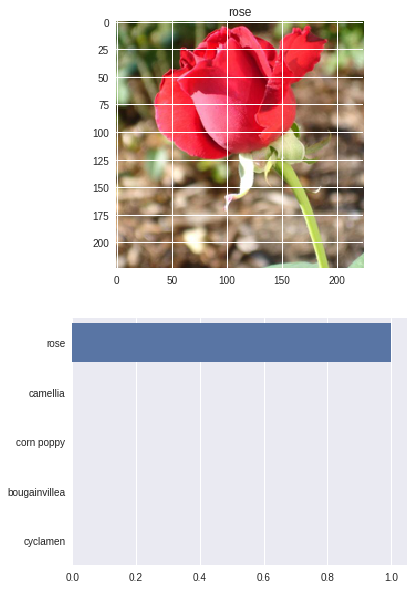

In [95]:
image_path = "drive/My Drive/Colab Notebooks/flower_data/valid/74/image_01310.jpg"
plot_solution(image_path, model2)